In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)

### Functions that will be used in this dataframe

In [ ]:
def prepare_regression_df(feature_df, salary_df, binarized_cols, csv_name, delete_original_col = True, drop_NA = True):
    '''
    This function prepare data to fit in regression. 
        (Binarize categorical columns, drop NA values, and merge dependent and independent variables)
    
    Parameters:
        feature_df: takes a df. The df contains independent variable
        salary: takes a df. The df contains dependent variable
        binarized_cols: takes a list of columns. Columns need to be binarized
        csv_name: takes a string. The name of the csv file which stores clean data
        delete_original_col: Boolean. Whether to delete the categorical columns after binarized.
        drop_NA: Boolean. Whether to drop NA value for this df. 
    
    Return: clean df to fit in regression analysis.
    '''
    temp_feature_df = feature_df.copy(deep = True)
    if drop_NA:
        temp_feature_df = feature_df.dropna().reset_index(drop = True)
    
    #binarize
    temp_feature_df = pd.concat([temp_feature_df, pd.get_dummies(temp_feature_df[binarized_cols], prefix = ['B_'+ c for c in binarized_cols])] , axis = 1)
    if delete_original_col:
        temp_feature_df = temp_feature_df.drop(binarized_cols, axis=1 )
    
    result_df = pd.merge(temp_feature_df, salary_df, how='inner', left_on="jobId", right_on="jobId")  
    print('There are %d NA values: ' %result_df.isnull().values.any())
    
    #save to csv_file:
    result_df.to_csv('data/' + csv_name + '.csv', index=False)
    
    print('There are %0.2f %% data left after this process: ' %(len(result_df)*100/len(feature_df)))
    
    return result_df

# 1. Visualize Data 

In [2]:
#import dataset as a dataframe, and check the shape.
features_df = pd.read_csv("data/features.csv")
print(features_df.shape)
features_df.head()

(1000113, 8)


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [3]:
salaries_df = pd.read_csv("data/salaries.csv")
print(salaries_df.shape)
salaries_df.head()

(1000069, 2)


,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


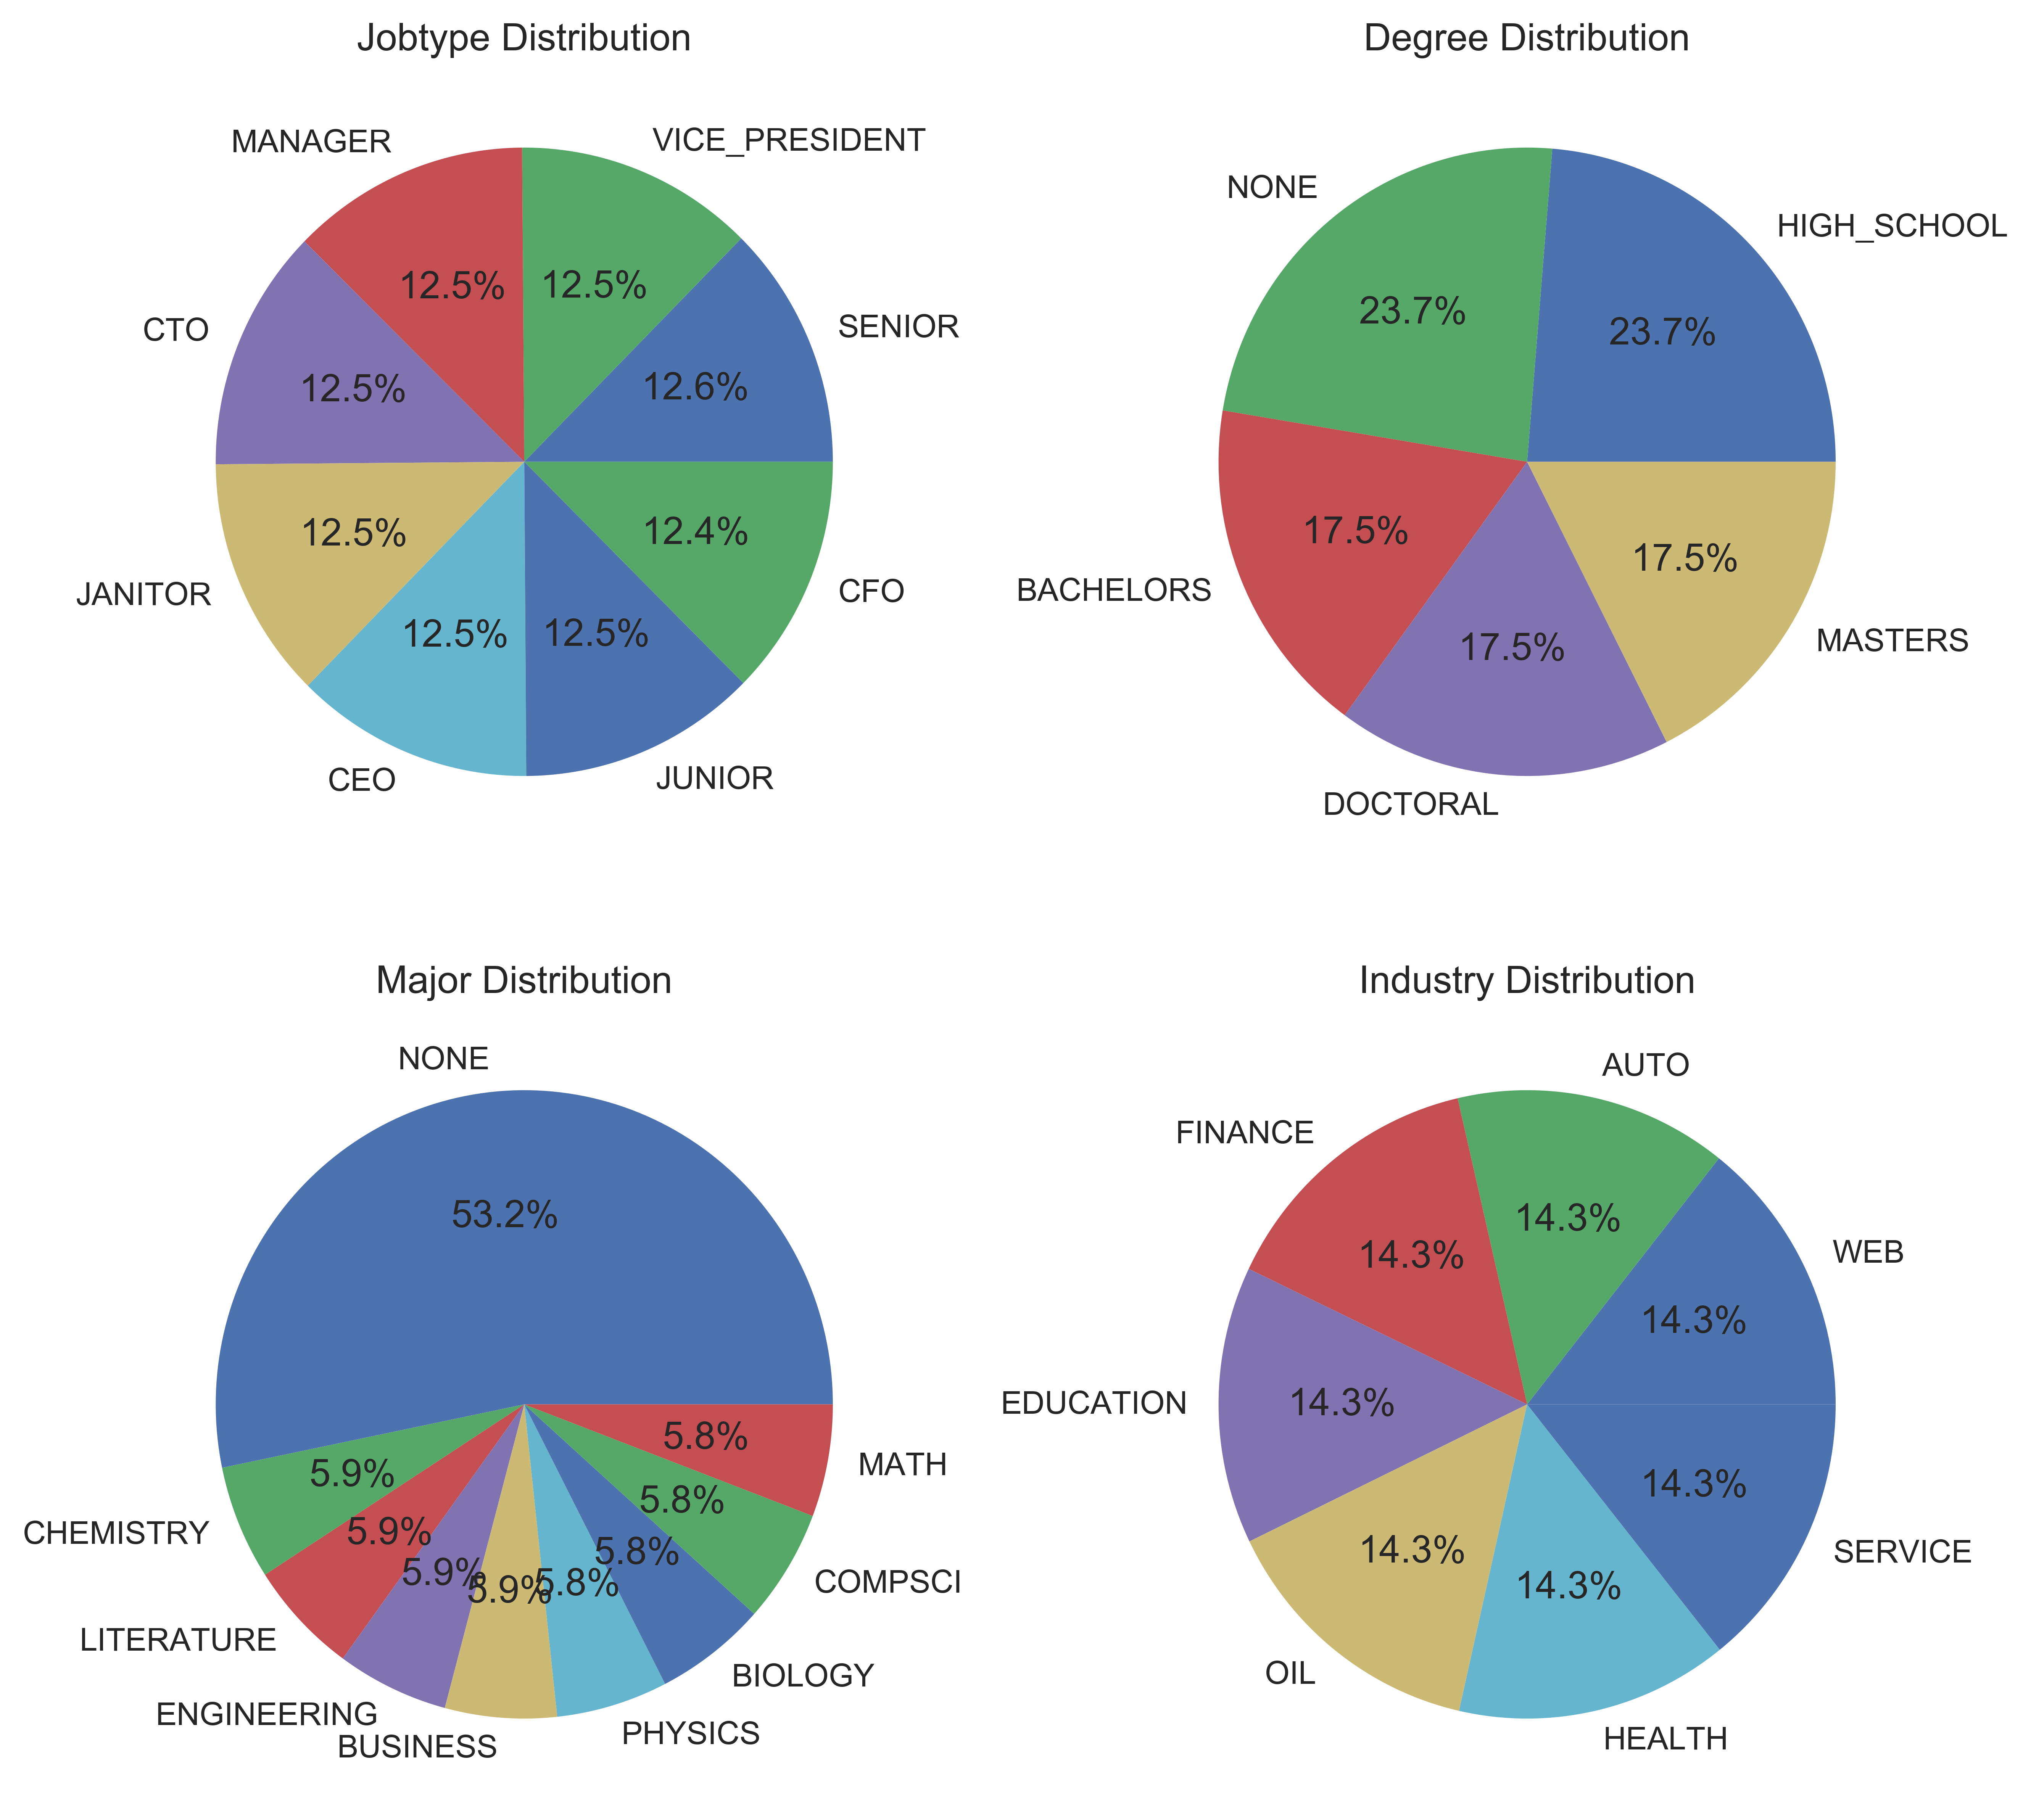

In [4]:
#visualize categorical columns: 'jobType', 'degree', 'major', 'industry'

#Set magic number for displaying bar chart.
bar_ylim_top = 1.1
bar_ylim_bottom = 0.9

fig, axes = plt.subplots(2,2, figsize = (10, 10),dpi= 600) 


categorical_cols = ['jobType', 'degree', 'major', 'industry']
col_index = 0

for i in range(2):
    for j in range(2):
        each_series = features_df[categorical_cols[col_index]].value_counts()
        axes[i,j].pie(each_series, labels = each_series.index, autopct='%1.1f%%')
        axes[i,j].set_title((categorical_cols[col_index]+' Distribution').title())
        col_index += 1
plt.subplots_adjust(hspace= 0.2, wspace= 0.3)        

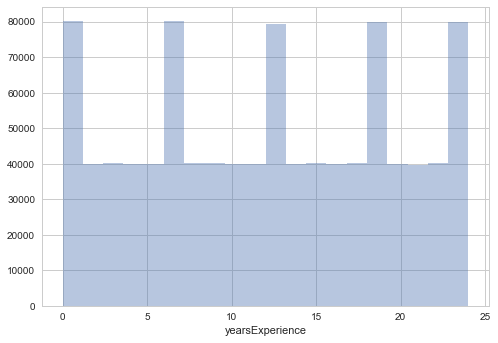

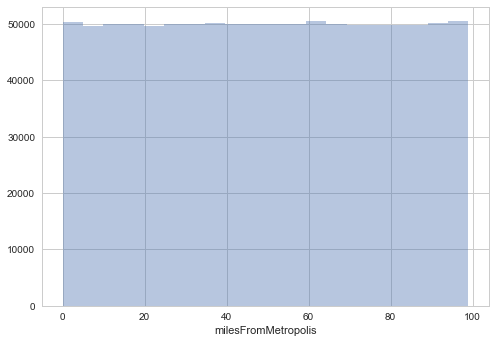

In [5]:
for each_col in ['yearsExperience', 'milesFromMetropolis']:
    sns.distplot(features_df[each_col], kde= False, bins= 20);
    plt.show()

C:\Users\qifan\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: order is deprecated, use sort_values(...)


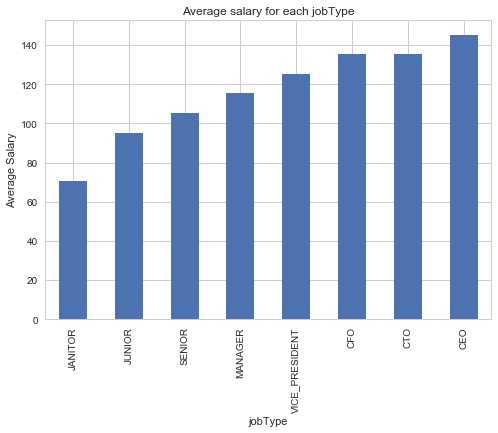

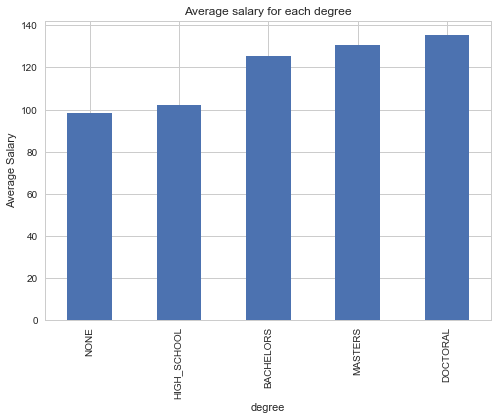

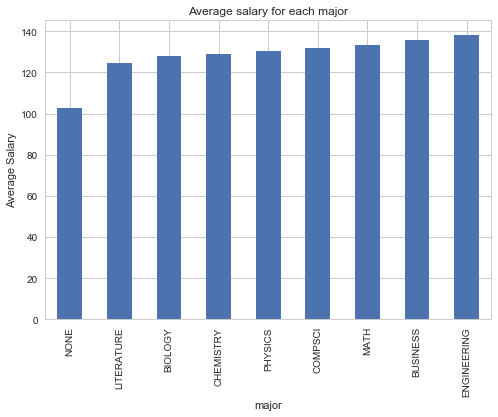

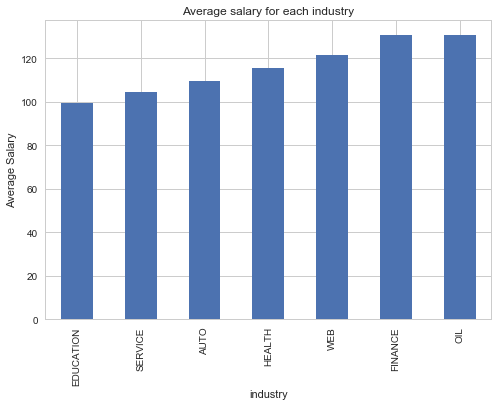

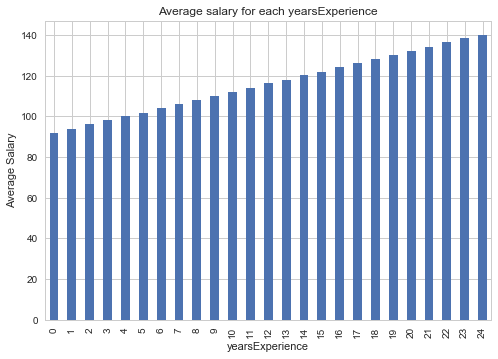

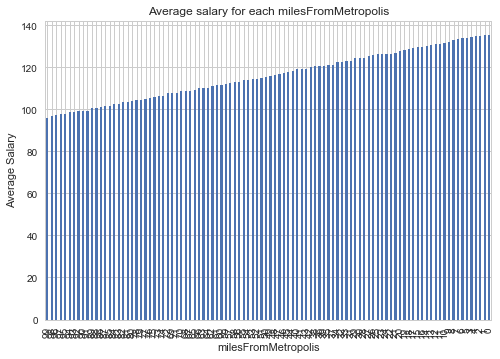

In [6]:
complete_df = pd.merge(features_df, salaries_df, how='inner', left_on="jobId", right_on="jobId")  

for each_col in categorical_cols + ['yearsExperience', 'milesFromMetropolis']:
    temp_df = complete_df.groupby(each_col).agg(np.mean)
    temp_df = temp_df['salary'].order()
    temp_df.plot(kind='bar', title='Average salary for each '+ each_col)
    plt.xlabel(each_col)
    plt.ylabel('Average Salary')
    plt.show()

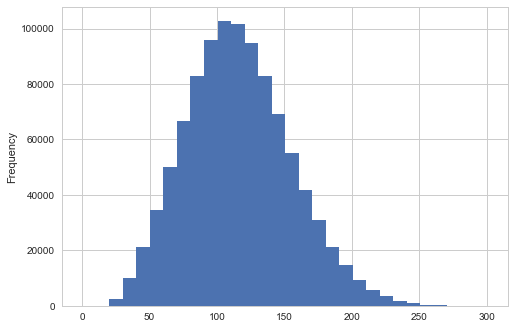

In [7]:
#Visualize the salary distribution
complete_df['salary'].plot.hist(bins=30)

In [8]:
#replace all "None" values to NaN value, and find rows that has "NaN" values and store them in nan_df.  
features_replace_na = features_df.replace('NONE', np.nan)
nan_df = features_replace_na[features_replace_na.isnull().any(axis= 1)].reset_index(drop = True)
print('''%0.2f percent rows has missing values''' %(len(nan_df)*100/len(features_df)))
nan_df.head()

53.24 percent rows has missing values


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NaN,WEB,3,73
1,JOB1362684407693,COMP15,CFO,NaN,NaN,HEALTH,23,24
2,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NaN,EDUCATION,1,54
3,JOB1362684407697,COMP56,JANITOR,HIGH_SCHOOL,NaN,HEALTH,24,30
4,JOB1362684407699,COMP4,JUNIOR,NaN,NaN,OIL,8,29


In [9]:
#Use a dictionary, count_nan_dict, to store how many missing values for each column.
count_nan_dict={}
for col in range(len(nan_df.columns)):
    count=nan_df.ix[:,col].isnull().sum()
    col_name=nan_df.columns[col]
    count_nan_dict[col_name]=count

count_nan_dict

{'companyId': 0,
 'degree': 236881,
 'industry': 0,
 'jobId': 0,
 'jobType': 0,
 'major': 532419,
 'milesFromMetropolis': 0,
 'yearsExperience': 0}

# 2. Data Cleaning

### I use 3 approaches to clean the data: Remove_na_rows, Remove_major_and_na, and Convert_columns. 
### I will use regression results to select which approach is the best.

# Remove_na_rows
1:remove all rows that has missing values <br/>
2:Store the remaining rows in a dataframe called: remove_na_df  <br/>
3:Inner join with salaries_df. This process left with nearly 50% of data<br/>


In [12]:
remove_na_df = prepare_regression_df(features_replace_na, salaries_df, categorical_cols +['companyId'], 'remove_na_clean_data')
remove_na_df.columns

There are 0 NA values: 
There are 46.77 % data left after this process: 


Index(['jobId', 'yearsExperience', 'milesFromMetropolis', 'B_jobType_CEO',
       'B_jobType_CFO', 'B_jobType_CTO', 'B_jobType_JUNIOR',
       'B_jobType_MANAGER', 'B_jobType_SENIOR', 'B_jobType_VICE_PRESIDENT',
       'B_degree_BACHELORS', 'B_degree_DOCTORAL', 'B_degree_MASTERS',
       'B_major_BIOLOGY', 'B_major_BUSINESS', 'B_major_CHEMISTRY',
       'B_major_COMPSCI', 'B_major_ENGINEERING', 'B_major_LITERATURE',
       'B_major_MATH', 'B_major_PHYSICS', 'B_industry_AUTO',
       'B_industry_EDUCATION', 'B_industry_FINANCE', 'B_industry_HEALTH',
       'B_industry_OIL', 'B_industry_SERVICE', 'B_industry_WEB',
       'B_companyId_COMP0', 'B_companyId_COMP1', 'B_companyId_COMP10',
       'B_companyId_COMP11', 'B_companyId_COMP12', 'B_companyId_COMP13',
       'B_companyId_COMP14', 'B_companyId_COMP15', 'B_companyId_COMP16',
       'B_companyId_COMP17', 'B_companyId_COMP18', 'B_companyId_COMP19',
       'B_companyId_COMP2', 'B_companyId_COMP20', 'B_companyId_COMP21',
       'B_companyI

# Remove_major_and_na
1:Remove the column 'major' (because 'major' has the most number of missing values).<br/>
2:Remove all rows that have missing value and store the remaining rows in a dataframe called: remove_major_na_df <br/>
3:Inner join the salaries with remove_major_na_df. This process left with 76% data.<br/>


In [14]:
#remove the column "major" 
remove_major_na_df = features_replace_na.ix[:, features_replace_na.columns != 'major']

remove_major_na_df= prepare_regression_df(remove_major_na_df, salaries_df, ['companyId', 'jobType', 'degree', 'industry'], 'remove_major_na_clean_data')
remove_major_na_df.columns

There are 0 NA values: 
There are 76.32 % data left after this process: 


Index(['jobId', 'yearsExperience', 'milesFromMetropolis', 'B_companyId_COMP0',
       'B_companyId_COMP1', 'B_companyId_COMP10', 'B_companyId_COMP11',
       'B_companyId_COMP12', 'B_companyId_COMP13', 'B_companyId_COMP14',
       'B_companyId_COMP15', 'B_companyId_COMP16', 'B_companyId_COMP17',
       'B_companyId_COMP18', 'B_companyId_COMP19', 'B_companyId_COMP2',
       'B_companyId_COMP20', 'B_companyId_COMP21', 'B_companyId_COMP22',
       'B_companyId_COMP23', 'B_companyId_COMP24', 'B_companyId_COMP25',
       'B_companyId_COMP26', 'B_companyId_COMP27', 'B_companyId_COMP28',
       'B_companyId_COMP29', 'B_companyId_COMP3', 'B_companyId_COMP30',
       'B_companyId_COMP31', 'B_companyId_COMP32', 'B_companyId_COMP33',
       'B_companyId_COMP34', 'B_companyId_COMP35', 'B_companyId_COMP36',
       'B_companyId_COMP37', 'B_companyId_COMP38', 'B_companyId_COMP39',
       'B_companyId_COMP4', 'B_companyId_COMP40', 'B_companyId_COMP41',
       'B_companyId_COMP42', 'B_companyId_COMP43'

# Convert_columns
1:convert all columns that have categorical variables into dummy columns(including None value)<br/>
2:inner join with salaries, and this process keeps all data<br/>


In [15]:
#convert the all categorical columns into dummy columns, and don't drop any NA value. 
convert_columns = prepare_regression_df(features_df, salaries_df, categorical_cols +['companyId'], 'convert_columns_clean_data', drop_NA = False)
convert_columns.head()

There are 0 NA values: 
There are 100.01 % data left after this process: 


,jobId,yearsExperience,milesFromMetropolis,B_jobType_CEO,B_jobType_CFO,B_jobType_CTO,B_jobType_JANITOR,B_jobType_JUNIOR,B_jobType_MANAGER,B_jobType_SENIOR,...,B_companyId_COMP58,B_companyId_COMP59,B_companyId_COMP6,B_companyId_COMP60,B_companyId_COMP61,B_companyId_COMP62,B_companyId_COMP7,B_companyId_COMP8,B_companyId_COMP9,salary
0,JOB1362684407687,10,83,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,130
1,JOB1362684407688,3,73,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,101
2,JOB1362684407689,10,38,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,137
3,JOB1362684407690,8,17,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,142
4,JOB1362684407691,8,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,163
